### Import relevant variables

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('/home/abhirup/Documents/Work/testGR_IR/src')
sys.path.append('/home/abhirup/Documents/Work/gr_consistency_highermodes/src')
import bayesian as ba
import imrtestgr as tgr
import scipy
from scipy import interpolate
import read_emcee_samples as res

### Functions to compute credible levels and confidence intervals

In [2]:
# Module for confidence calculations
class confidence(object):
    def __init__(self, counts):
        # Sort in descending order in frequency
        self.counts_sorted = np.sort(counts.flatten())[::-1]
        # Get a normalized cumulative distribution from the mode
        self.norm_cumsum_counts_sorted = np.cumsum(self.counts_sorted) / np.sum(counts)
        # Set interpolations between heights, bins and levels
        self._set_interp()
    def _set_interp(self):
        self._length = len(self.counts_sorted)
        # height from index
        self._height_from_idx = interpolate.interp1d(np.arange(self._length), self.counts_sorted, bounds_error=False, fill_value=0.)
        # index from height
        self._idx_from_height = interpolate.interp1d(self.counts_sorted[::-1], np.arange(self._length)[::-1], bounds_error=False, fill_value=self._length)
        # level from index
        self._level_from_idx = interpolate.interp1d(np.arange(self._length), self.norm_cumsum_counts_sorted, bounds_error=False, fill_value=1.)
        # index from level
        self._idx_from_level = interpolate.interp1d(self.norm_cumsum_counts_sorted, np.arange(self._length), bounds_error=False, fill_value=self._length)
    def level_from_height(self, height):
        return self._level_from_idx(self._idx_from_height(height))
    def height_from_level(self, level):
        return self._height_from_idx(self._idx_from_level(level))

# compute 1-sigma confidence intervals in 1D 
def calc_cred_intervals_in_1d(P, x):

        # find the value of P corresponding to 50% and 9% confidence heights 
        conf = confidence(P)
        P_s1 = conf.height_from_level(0.5)
        P_s2 = conf.height_from_level(0.9)

        # calculation of condifence edges (values of x corresponding to the height s1 on the two sides) 
        x_s1_l = min(x[np.where(P >= P_s1)[0]])
        x_s1_r = max(x[np.where(P >= P_s1)[0]])

        # calculation of condifence edges (values of x corresponding to the height s2 on the two sides) 
        x_s2_l = min(x[np.where(P >= P_s2)[0]])
        x_s2_r = max(x[np.where(P >= P_s2)[0]])

        return P_s1, P_s2, x_s1_l, x_s1_r, x_s2_l, x_s2_r

### Define some variables universal for all SNR runs

In [3]:
nwalkers, ndim = 100, 11
color = ['c', 'k', '#0072b2', '#CC79A7']
snr_list = [10, 15, 20, 25, 30, 40, 50]

### Plotting DeltaMc-Deltaq plots for each case: SNR=10,15,20,25,30,40,50

SNR = 10; 90percent CI on DeltaMc = 358.65; 90percent CI on Deltaq = 1.76874


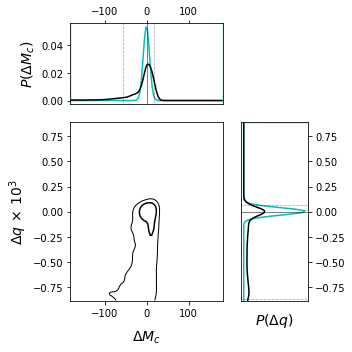

SNR = 15; 90percent CI on DeltaMc = 0.15; 90percent CI on Deltaq = 0.00097


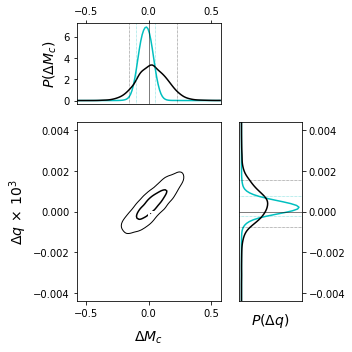

SNR = 20; 90percent CI on DeltaMc = 0.11; 90percent CI on Deltaq = 0.00067


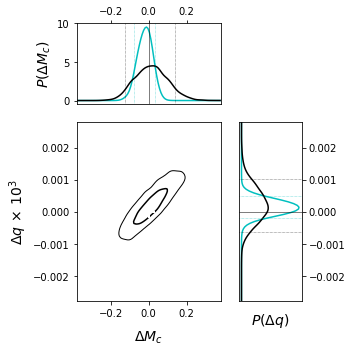

SNR = 25; 90percent CI on DeltaMc = 0.10; 90percent CI on Deltaq = 0.00056


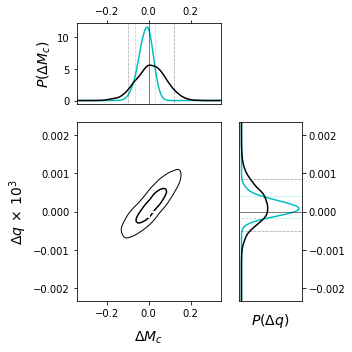

SNR = 30; 90percent CI on DeltaMc = 0.08; 90percent CI on Deltaq = 0.00045


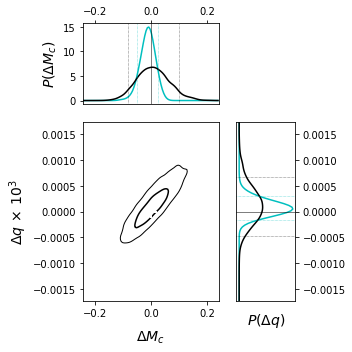

SNR = 40; 90percent CI on DeltaMc = 0.05; 90percent CI on Deltaq = 0.00032


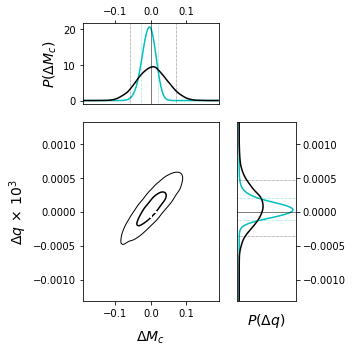

SNR = 50; 90percent CI on DeltaMc = 0.04; 90percent CI on Deltaq = 0.00023


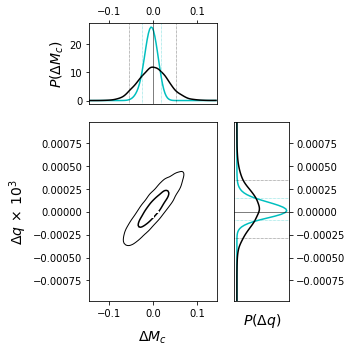

In [4]:
dmc_90_CI = []
dq_90_CI = []

for (idx,snr) in enumerate(snr_list):

    if snr == 10:
        num_iter, n_burnin = 10000, 5000
    else:
        num_iter, n_burnin = 3000, 1000
    
    if snr == 25:
        
        post_loc_dmcdq = '/home/abhirup/Documents/Work/gr_consistency_highermodes/runs/9_param_runs/Mc_q_deltaMc_deltaq/M_80_q_9_iota_60/emcee_samples.dat'
        post_loc_dmc = '/home/abhirup/Documents/Work/gr_consistency_highermodes/runs/9_param_runs/Mc_q_deltaMc_deltaq/M_80_q_9_iota_60_deltaMc/emcee_samples.dat'
        post_loc_dq = '/home/abhirup/Documents/Work/gr_consistency_highermodes/runs/9_param_runs/Mc_q_deltaMc_deltaq/M_80_q_9_iota_60_deltaq/emcee_samples.dat'

    else:
        
        post_loc_dmcdq = '/home/abhirup/Documents/Work/gr_consistency_highermodes/runs/9_param_runs/Mc_q_deltaMc_deltaq/M_80_q_9_iota_60_SNR_%d/emcee_samples.dat'%snr
        post_loc_dmc = '/home/abhirup/Documents/Work/gr_consistency_highermodes/runs/9_param_runs/Mc_q_deltaMc_deltaq/M_80_q_9_iota_60_deltaMc_SNR_%d/emcee_samples.dat'%snr
        post_loc_dq = '/home/abhirup/Documents/Work/gr_consistency_highermodes/runs/9_param_runs/Mc_q_deltaMc_deltaq/M_80_q_9_iota_60_deltaq_SNR_%d/emcee_samples.dat'%snr

        
    mc, q, mc1, q1, dL, i, t0, phi0, ra, sin_dec, pol = res.read_emcee_samples_11dim(post_loc_dmcdq, nwalkers, num_iter, ndim, n_burnin)
    dmc_2d, dq_2d = mc - mc1, q - q1

    mc, q, mc1, q1, dL, i, t0, phi0, ra, sin_dec, pol = res.read_emcee_samples_11dim(post_loc_dmc, nwalkers, num_iter, ndim, n_burnin)
    dmc_1d = mc - mc1

    mc, q, mc1, q1, dL, i, t0, phi0, ra, sin_dec, pol = res.read_emcee_samples_11dim(post_loc_dq, nwalkers, num_iter, ndim, n_burnin)
    dq_1d = q - q1

    Nbins = 101
    
    dmc_lim = max(max(np.absolute(dmc_2d)),max(np.absolute(dmc_1d)))
    dq_lim = max(max(np.absolute(dq_2d)),max(np.absolute(dq_1d)))
    dmc_bins = np.linspace(-dmc_lim, dmc_lim, Nbins)
    dq_bins = np.linspace(-dq_lim, dq_lim, Nbins)
    dmc = np.mean(np.diff(dmc_bins))
    dq = np.mean(np.diff(dq_bins))

    dmc_intp = (dmc_bins[:-1] + dmc_bins[1:])/2.
    dq_intp = (dq_bins[:-1] + dq_bins[1:])/2.

    P_dmc_dq_2d, dmc_bins, dq_bins = np.histogram2d(dmc_2d, dq_2d, bins=(dmc_bins, dq_bins), normed=True)
    P_dmc_dq_2d = P_dmc_dq_2d.T
    P_dmc_marg = np.sum(P_dmc_dq_2d, axis=0) * dq
    P_dq_marg = np.sum(P_dmc_dq_2d, axis=1) * dmc

    P_dmc_1d, dmc_bins = np.histogram(dmc_1d,bins=dmc_bins, normed=True)
    P_dq_1d, dq_bins = np.histogram(dq_1d,bins=dq_bins, normed=True)

    s1_2d = ba.nsigma_value(P_dmc_dq_2d, 0.5)
    s2_2d = ba.nsigma_value(P_dmc_dq_2d, 0.9)

    s1_1d_v1, s2_1d_v1, left1_1d_v1, right1_1d_v1, left2_1d_v1, right2_1d_v1 = calc_cred_intervals_in_1d(P_dmc_1d, dmc_intp)
    s1_1d_v2, s2_1d_v2, left1_1d_v2, right1_1d_v2, left2_1d_v2, right2_1d_v2 = calc_cred_intervals_in_1d(P_dq_1d, dq_intp)

    s1_marg_v1, s2_marg_v1, left1_marg_v1, right1_marg_v1, left2_marg_v1, right2_marg_v1 = calc_cred_intervals_in_1d(P_dmc_marg, dmc_intp)
    s1_marg_v2, s2_marg_v2, left1_marg_v2, right1_marg_v2, left2_marg_v2, right2_marg_v2 = calc_cred_intervals_in_1d(P_dq_marg, dq_intp)

    dmc_90_CI = np.append(dmc_90_CI, right2_1d_v1-left2_1d_v1)
    dq_90_CI = np.append(dq_90_CI, right2_1d_v2-left2_1d_v2)    
    
    print 'SNR = %d; 90percent CI on DeltaMc = %.2f; 90percent CI on Deltaq = %.5f'%(snr, (right2_1d_v1-left2_1d_v1), (right2_1d_v2-left2_1d_v2))
        
    p = plt.figure(figsize=(5,5))
    ax1 = plt.subplot2grid((3,3), (0,0), colspan=2)
    ax2 = plt.subplot2grid((3,3), (1,2), rowspan=2)
    ax3 = plt.subplot2grid((3,3), (1,0), colspan=2, rowspan=2)    
    
    ax1.plot(dmc_intp, tgr.gf(P_dmc_1d),color=color[0], lw=1.5)
    ax1.plot(dmc_intp, tgr.gf(P_dmc_marg),color=color[1], lw=1.5)
    ax1.axvline(0.,color='k', ls='-', lw=0.5)
    ax1.axvline(x=left2_1d_v1, color=color[0], ls=':', lw=0.5)
    ax1.axvline(x=right2_1d_v1, color=color[0], ls=':', lw=0.5)
    ax1.axvline(x=left2_marg_v1, color=color[1], ls=':', lw=0.5)
    ax1.axvline(x=right2_marg_v1, color=color[1], ls=':', lw=0.5)
    ax1.set_ylabel('$P(\Delta M_c)$',fontsize=14)
    #ax1.set_xticks(np.arange(-0.2, 0.25, 0.1))
    #ax1.set_xticklabels(np.arange(-0.2, 0.25, 0.1), fontsize=12)
    ax1.set_xlim(-dmc_lim, dmc_lim)
    #ax1.set_ylim(0,np.max(P_dmc_1d)*1.01)
    ax1.xaxis.tick_top()
    #ax1.set_yticks([])

    #ax3.pcolormesh(dmc_bins, dq_bins, tgr.gf(P_dmc_dq_2d), cmap='RdPu')
    ax3.contour(dmc_intp, dq_intp, tgr.gf(P_dmc_dq_2d), levels=(s2_2d,s1_2d), linewidths=(1,1.5), colors=color[1])
    ax3.plot(0, 0, '+', color='white', ms=12, mew=2) # for mod gr make the marker k+ , for gr make the marker w+
    ax3.set_xlabel('$\Delta M_c ~ (M_\odot)$',fontsize=14, labelpad=10)
    ax3.set_ylabel('$\Delta q \, \\times \, 10^{3}$',fontsize=14)
    #ax3.set_xticks([])
    #ax3.set_yticks([])
    ax3.set_xlim(-dmc_lim, dmc_lim)
    ax3.set_ylim(-dq_lim, dq_lim)

    ax2.plot(tgr.gf(P_dq_1d), dq_intp,color=color[0], lw=1.5)
    ax2.plot(tgr.gf(P_dq_marg), dq_intp,color=color[1], lw=1.5)
    ax2.axhline(0.,color='k', ls='-', lw=0.5)
    ax2.axhline(y=left2_1d_v2, color=color[0], ls=':', lw=0.5)
    ax2.axhline(y=right2_1d_v2, color=color[0], ls=':', lw=0.5)
    ax2.axhline(y=left2_marg_v2, color=color[1], ls=':', lw=0.5)
    ax2.axhline(y=right2_marg_v2, color=color[1], ls=':', lw=0.5)
    ax2.set_xlabel('$P(\Delta q)$',fontsize=14, labelpad=10)
    ax2.set_xticks([])
    #ax2.set_yticks(np.arange(-0.0015, 0.0015, 0.0005))
    #ax2.set_yticklabels(np.arange(-1.5, 1.5, 0.5), fontsize=12)
    ax2.set_ylim(-dq_lim, dq_lim)
    #ax2.set_xlim(0,np.max(P_dq_1d)*1.01)
    ax2.yaxis.tick_right()
    plt.tight_layout()
    plt.show()

### Plotting 90% confidence intervals on the 1D DeltaMc and Deltaq posteriors, as obtained from the above results

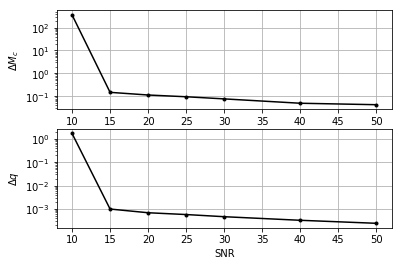

In [6]:
plt.plot(figsize=(10,8))
plt.subplot(211)
plt.semilogy(snr_list, dmc_90_CI, color='k', marker='.')
plt.ylabel('$\Delta M_c$')
plt.grid(True)
plt.subplot(212)
plt.semilogy(snr_list, dq_90_CI, color='k', marker='.')
plt.grid(True)
plt.ylabel('$\Delta q$')
plt.xlabel('SNR')
plt.show()